# Load and check datasets

## Notebook walkthrough

Run cells top-to-bottom to: (1) verify packages, (2) download/read MovieLens 32M locally, (3) continue into cleaning and analysis steps.


In [1]:
import pyspark
print(pyspark.__version__)

3.5.6


## Dataset source (local)

The setup cell downloads the MovieLens 32M CSVs into `data/movielens/32m` if they are missing and exposes `data_paths` for later steps.


In [2]:
from pathlib import Path
import subprocess
import sys

DATA_VARIANT = "32m"  # matches README
DATA_FILES = {
    "movies": "movies.csv",
    "ratings": "ratings.csv",
    "tags": "tags.csv",
    "links": "links.csv",
}


def find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "scripts" / "download_movielens.py").exists():
            return candidate
    raise FileNotFoundError("Could not locate repository root from the current working directory.")


def ensure_local_dataset(variant: str) -> Path:
    repo_root = find_repo_root(Path.cwd())
    variant_dir = repo_root / "data" / "movielens" / variant
    missing = [name for name in DATA_FILES.values() if not (variant_dir / name).exists()]
    if not missing:
        print(f"Using local files at {variant_dir}")
        return variant_dir

    script_path = repo_root / "scripts" / "download_movielens.py"
    if not script_path.exists():
        raise FileNotFoundError(f"Cannot find {script_path} to download MovieLens {variant}")

    print(f"Local files missing; downloading MovieLens {variant} via {script_path}")
    subprocess.run([sys.executable, str(script_path), "--variant", variant], check=True, cwd=repo_root)

    missing = [name for name in DATA_FILES.values() if not (variant_dir / name).exists()]
    if missing:
        raise FileNotFoundError(f"Download completed but missing files: {', '.join(missing)}")
    return variant_dir


local_data_dir = ensure_local_dataset(DATA_VARIANT)
data_paths = {
    name: str(local_data_dir / filename)
    for name, filename in DATA_FILES.items()
}

print("Reading from:", data_paths)


Using local files at c:\Users\User\github\TsungTseTu122\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\data\movielens\32m
Reading from: {'movies': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\movies.csv', 'ratings': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\ratings.csv', 'tags': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\tags.csv', 'links': 'c:\\Users\\User\\github\\TsungTseTu122\\CloudComputing--MovieLens-Big-Data-Analytics-on-the-Cloud\\data\\movielens\\32m\\links.csv'}


### Optional: Pandas preview (quick peek)

Use this to inspect the data with pandas; it loads a capped sample to stay lightweight.


In [3]:
import pandas as pd

movies_pd = pd.read_csv(data_paths["movies"])
ratings_pd = pd.read_csv(data_paths["ratings"], nrows=200000)  # adjust nrows as needed

print(movies_pd.head())
print(ratings_pd.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858


In [4]:
from pyspark.sql import SparkSession

# Create Spark session (local)
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName('MovieLensAnalysis')
    .config('spark.driver.memory', '2g')
    .config('spark.sql.shuffle.partitions', '8')
    .getOrCreate()
)

spark


In [5]:
# Load movies.csv (local)
movies_df = spark.read.csv(data_paths['movies'], header=True, inferSchema=True)

movies_df.show()


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [6]:
# Load tags.csv (local)
tags_df = spark.read.csv(data_paths['tags'], header=True, inferSchema=True)

tags_df.show()


+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    22|  26479|         Kevin Kline|1583038886|
|    22|  79592|            misogyny|1581476297|
|    22| 247150|          acrophobia|1622483469|
|    34|   2174|               music|1249808064|
|    34|   2174|               weird|1249808102|
|    34|   8623|        Steve Martin|1249808497|
|    55|   5766|the killls and th...|1319322078|
|    58|   7451|            bullying|1672551536|
|    58|   7451|              clique|1672551510|
|    58|   7451|       coming of age|1672551502|
|    58|   7451|              gossip|1672551527|
|    58|   7451|         high school|1672551496|
|    58|   7451|          teen movie|1672551500|
|    58|  49272|           '60s feel|1672551430|
|    58|  49272|                 007|1672551409|
|    58|  49272|              action|1672551403|
|    58|  49272|            assassin|1672551425|
|    58|  49272|    

In [7]:
# Load links.csv (local)
links_df = spark.read.csv(data_paths['links'], header=True, inferSchema=True)

links_df.show()



+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows



After accessing this dataset, which is simply links to IMDB and TMDB, it simply isn't worth analyzing, so we won't be using it but for display

In [8]:
# Load ratings.csv (local)
ratings_df = spark.read.csv(data_paths['ratings'], header=True, inferSchema=True)

ratings_df.show()


+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
|     1|     34|   2.0|943228491|
|     1|     36|   1.0|944249008|
|     1|     80|   5.0|944248943|
|     1|    110|   3.0|943231119|
|     1|    111|   5.0|944249008|
|     1|    161|   1.0|943231162|
|     1|    166|   5.0|943228442|
|     1|    176|   4.0|944079496|
|     1|    223|   3.0|944082810|
|     1|    232|   5.0|943228442|
|     1|    260|   5.0|943228696|
|     1|    302|   4.0|944253272|
|     1|    306|   5.0|944248888|
|     1|    307|   5.0|944253207|
|     1|    322|   4.0|944053801|
+------+-------+------+---------+
only showing top 20 rows



# Preprocessing

## Preprocessing Movies Data

In [9]:
from pyspark.sql.functions import regexp_extract

# Extract the year from the title using regex
movies_df = movies_df.withColumn("year", regexp_extract(movies_df["title"], r'\((\d{4})\)', 1))

# Clean title by removing the year
movies_df = movies_df.withColumn("clean_title", regexp_extract(movies_df["title"], r'^(.*)\s\(\d{4}\)$', 1))

# Create new DataFrame and drop the original 'title' column
split_movies_df = movies_df.drop("title")

# Show the resulting DataFrame
split_movies_df.show()



+-------+--------------------+----+--------------------+
|movieId|              genres|year|         clean_title|
+-------+--------------------+----+--------------------+
|      1|Adventure|Animati...|1995|           Toy Story|
|      2|Adventure|Childre...|1995|             Jumanji|
|      3|      Comedy|Romance|1995|    Grumpier Old Men|
|      4|Comedy|Drama|Romance|1995|   Waiting to Exhale|
|      5|              Comedy|1995|Father of the Bri...|
|      6|Action|Crime|Thri...|1995|                Heat|
|      7|      Comedy|Romance|1995|             Sabrina|
|      8|  Adventure|Children|1995|        Tom and Huck|
|      9|              Action|1995|        Sudden Death|
|     10|Action|Adventure|...|1995|           GoldenEye|
|     11|Comedy|Drama|Romance|1995|American Presiden...|
|     12|       Comedy|Horror|1995|Dracula: Dead and...|
|     13|Adventure|Animati...|1995|               Balto|
|     14|               Drama|1995|               Nixon|
|     15|Action|Adventure|...|1

## Preprocessing Tags Data

I think the time that a user tags a certain movie is less useful and can depend on different factors like when the user finishes his movie, so I took it out. We also have the release year of the movie which is enough for trend analysis.

In [10]:
# Drop the 'timestamp' column from tags_df
tags_df_clean = tags_df.drop("timestamp")

# Show the updated DataFrame
tags_df_clean.show()



+------+-------+--------------------+
|userId|movieId|                 tag|
+------+-------+--------------------+
|    22|  26479|         Kevin Kline|
|    22|  79592|            misogyny|
|    22| 247150|          acrophobia|
|    34|   2174|               music|
|    34|   2174|               weird|
|    34|   8623|        Steve Martin|
|    55|   5766|the killls and th...|
|    58|   7451|            bullying|
|    58|   7451|              clique|
|    58|   7451|       coming of age|
|    58|   7451|              gossip|
|    58|   7451|         high school|
|    58|   7451|          teen movie|
|    58|  49272|           '60s feel|
|    58|  49272|                 007|
|    58|  49272|              action|
|    58|  49272|            assassin|
|    58|  49272|         bittersweet|
|    58|  49272|              casino|
|    58|  49272|        Daniel Craig|
+------+-------+--------------------+
only showing top 20 rows



## Preprocessing Ratings Data

In [11]:
# Drop the timestamp column
ratings_df_clean = ratings_df.drop("timestamp")

# Show the cleaned DataFrame without the timestamp
ratings_df_clean.show()


+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|     17|   4.0|
|     1|     25|   1.0|
|     1|     29|   2.0|
|     1|     30|   5.0|
|     1|     32|   5.0|
|     1|     34|   2.0|
|     1|     36|   1.0|
|     1|     80|   5.0|
|     1|    110|   3.0|
|     1|    111|   5.0|
|     1|    161|   1.0|
|     1|    166|   5.0|
|     1|    176|   4.0|
|     1|    223|   3.0|
|     1|    232|   5.0|
|     1|    260|   5.0|
|     1|    302|   4.0|
|     1|    306|   5.0|
|     1|    307|   5.0|
|     1|    322|   4.0|
+------+-------+------+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import collect_set, first, split, col, trim

# Join tags_df_clean and ratings_df_clean on both 'movieId' and 'userId'
movies_tags_ratings_df = tags_df_clean.join(ratings_df_clean, on=["movieId", "userId"], how="inner")

# Join the result with split_movies_df on 'movieId' to get the genre, year, and title
merged_df = movies_tags_ratings_df.join(split_movies_df, on="movieId", how="inner")

# One final dataframe: filter bad titles, collapse tags per user/movie, split genres
final_df = (
    merged_df
    .filter((col("clean_title").isNotNull()) & (trim(col("clean_title")) != ""))
    .groupBy("userId", "movieId")
    .agg(
        first("rating").alias("rating"),
        first("genres").alias("genres"),
        first("year").alias("year"),
        first("clean_title").alias("clean_title"),
        collect_set("tag").alias("tags"),
    )
    .withColumn("genres", split(col("genres"), "\|"))
)


# Show final merge
final_df.show()



+------+-------+------+--------------------+----+--------------------+--------------------+
|userId|movieId|rating|              genres|year|         clean_title|                tags|
+------+-------+------+--------------------+----+--------------------+--------------------+
|    58|  61132|   4.5|[Action, Adventur...|2008|      Tropic Thunder|[funny, jungle, M...|
|   109|      1|   4.0|[Adventure, Anima...|1995|           Toy Story|  [Disney, children]|
|   109|     50|   5.0|[Crime, Mystery, ...|1995| Usual Suspects, The|[Kevin Spacey, Cr...|
|   109|   1025|   3.5|[Animation, Child...|1963|Sword in the Ston...|[Disney, magic, C...|
|   109|  48543|   4.0|[Crime, Drama, Ho...|2005|Antibodies (Antik...|[crime, german, t...|
|   109|  51357|   3.5|[Crime, Drama, Th...|1995|           Citizen X|[crime, Stephen R...|
|   109|  61948|   2.5|  [Horror, Thriller]|2008|            100 Feet|[house arrest, gh...|
|   109|  66659|   3.0|[Comedy, Crime, D...|2009|Tyler Perry's Mad...|[tyler per

## Check for outliers

In [13]:
import plotly.express as px
import pandas as pd

outlier_pd = final_df.select('rating', 'year').toPandas()
outlier_pd['year'] = pd.to_numeric(outlier_pd['year'], errors='coerce')

# Rating boxplot with hover
fig_box = px.box(
    outlier_pd,
    x="rating",
    title="Rating Distribution",
    points="outliers",
    color_discrete_sequence=["#4C78A8"]
)
fig_box.update_layout(
    template="simple_white",
    xaxis_title="Rating",
    margin=dict(l=40, r=20, t=50, b=40)
)

# Year histogram with nicer bins and formatting
valid_years = outlier_pd['year'].dropna()
fig_hist = px.histogram(
    valid_years,
    x="year",
    nbins=40,
    title="Year Distribution",
    labels={"year": "Year", "count": "Frequency"},
    color_discrete_sequence=["#4C78A8"]
)
fig_hist.update_layout(
    template="simple_white",
    bargap=0.05,
    margin=dict(l=40, r=20, t=50, b=40)
)
fig_hist.update_xaxes(dtick=5, tickangle=45)

fig_box.show()
fig_hist.show()


### Outlier interpretation
- Ratings: look for extreme lows/highs; the boxplot shows skew and potential outliers.
- Years: histogram reveals sparse early years and dense recent releases; treat early-year spikes cautiously.


### Rating Distribution Notes
- Ratings skew toward ~4.0 with a long left tail; 0.5 scores are rare but kept as real negative signals.
- Use this view to decide any trimming or weighting before modeling.

# Big Data queries with SparkSQL

## Numeric features distribution

In [14]:
# Display numerical columns, 'rating' and 'year'
final_df.describe(["rating", "year"]).show()


+-------+------------------+------------------+
|summary|            rating|              year|
+-------+------------------+------------------+
|  count|            260871|            260871|
|   mean| 3.701689724039851|2000.2981550268141|
| stddev|1.0626033987054273| 17.39476631426532|
|    min|               0.5|              1874|
|    max|               5.0|              2023|
+-------+------------------+------------------+



### Interpretation (Ratings + Years)
- Ratings: right-skewed toward higher scores; consider calibration if your model over-predicts the mean.
- Years: coverage grows sharply after the 1980s; early years are sparse, so treat pre-1950 trends cautiously.

## Common Genre

In [15]:
from pyspark.sql.functions import explode

# Explode the genres column to get individual genres 
genres_exploded = final_df.withColumn("genre", explode(final_df["genres"]))

# Count each genre occurrence
genres_count = genres_exploded.groupBy("genre").count().orderBy("count", ascending=False)
genres_count.show()



+------------------+------+
|             genre| count|
+------------------+------+
|             Drama|126678|
|            Comedy| 76892|
|          Thriller| 72984|
|            Action| 67616|
|            Sci-Fi| 51086|
|         Adventure| 49756|
|             Crime| 41824|
|           Romance| 40956|
|           Fantasy| 28249|
|            Horror| 27522|
|           Mystery| 25948|
|         Animation| 16373|
|          Children| 14667|
|              IMAX| 12651|
|               War| 11443|
|           Musical|  6754|
|       Documentary|  6020|
|           Western|  3689|
|         Film-Noir|  3128|
|(no genres listed)|  1511|
+------------------+------+



In [17]:
import plotly.express as px
import pandas as pd

genres_count_pd = genres_count.toPandas().sort_values("count", ascending=False).head(10)

fig = px.bar(
    genres_count_pd,
    x="count",
    y="genre",
    orientation="h",
    color="genre",  # keep colors per genre
    text="count",   # per-row text
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={"count": ":, "}
)
fig.update_traces(textposition="outside", texttemplate="%{text:,}")

fig.update_layout(
    title="Top 10 Genres by Count",
    title_x=0.5,
    xaxis_title="Count",
    yaxis_title="Genre",
    showlegend=False,
    template="simple_white",
    height=500,
    margin=dict(l=80, r=40, t=60, b=60)
)

fig.show()


## Top rating count of movies
Movies with the highest rating volumes; highlights the head of the distribution before the long tail of sparsely rated titles.

In [18]:
# Count how many times each movie has been rated
top_movies_by_ratings = final_df.groupBy("clean_title").count().orderBy("count", ascending=False)
top_movies_by_ratings.show(10)


+--------------------+-----+
|         clean_title|count|
+--------------------+-----+
|Star Wars: Episod...| 1420|
|        Pulp Fiction|  951|
|Shawshank Redempt...|  802|
|          Fight Club|  736|
|           Inception|  735|
|         Matrix, The|  717|
|        Forrest Gump|  691|
|        Interstellar|  634|
|Silence of the La...|  563|
|             Memento|  560|
+--------------------+-----+
only showing top 10 rows



In [20]:
import plotly.express as px
import pandas as pd

top_movies_by_ratings_pd = top_movies_by_ratings.limit(10).toPandas()
top_movies_by_ratings_pd = top_movies_by_ratings_pd.sort_values(by="count", ascending=False)

fig = px.bar(
    top_movies_by_ratings_pd,
    x="count",
    y="clean_title",
    orientation="h",
    color="clean_title",
    text="count",
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={"count": ":, "}
)
fig.update_traces(textposition="outside", texttemplate="%{text:,}")

fig.update_layout(
    title="Top 10 Most Rated Movies (by count)",
    title_x=0.5,
    xaxis_title="Number of Ratings",
    yaxis_title="Movie Title",
    showlegend=False,
    template="simple_white",
    height=500,
    margin=dict(l=100, r=40, t=60, b=60)
)

fig.show()


## Top 10 movies with highest ratings

Most-rated titles with a rating-count threshold; use the annotations to see both average rating and rating volume for context.

In [25]:
import plotly.express as px
import pandas as pd

# Compute top movies as before
movie_ratings_df = final_df.groupBy("movieId", "clean_title") \
    .agg(
        avg("rating").alias("avg_rating"),
        count("rating").alias("rating_count")
    )
threshold = 500
filtered_movies_df = movie_ratings_df.filter(movie_ratings_df["rating_count"] > threshold)
top_movies_df = filtered_movies_df.orderBy("avg_rating", ascending=False)
top_10_movies_df = top_movies_df.limit(10)

# Convert to pandas for plotting
top_10_movies_pd = top_10_movies_df.toPandas().sort_values(by="avg_rating", ascending=False)

fig = px.bar(
    top_10_movies_pd,
    x="avg_rating",
    y="clean_title",
    orientation="h",
    color="clean_title",
    text=top_10_movies_pd.apply(
        lambda r: f"{r['avg_rating']:.2f} | {int(r['rating_count']):,} ratings", axis=1
    ),
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={
        "avg_rating": ":.2f",
        "rating_count": ":, "
    }
)

fig.update_traces(
    textposition="inside",            # keep text inside the bar
    texttemplate="%{text}", 
    textfont_size=12,
    insidetextanchor="middle",
    insidetextfont_color="white"
)
fig.update_layout(
    title="Top 10 Highest Rated Movies (filtered by rating count)",
    title_x=0.5,
    xaxis_title="Average Rating",
    yaxis_title="Movie Title",
    showlegend=False,
    template="simple_white",
    height=600,
    margin=dict(l=150, r=140, t=60, b=60)
)

fig.show()


## Common Tag Cloud
Quick view of the most frequent tags; pair with genre stats to see whether user tags align with catalog metadata.

In [26]:
from pyspark.sql.functions import explode

# Count how many times each tag appears (explode tags array)
top_tags = final_df.select(explode("tags").alias("tag")).groupBy("tag").count().orderBy("count", ascending=False)
top_tags.show(10)


+------------------+-----+
|               tag|count|
+------------------+-----+
|            sci-fi|10487|
|       atmospheric| 9295|
|            action| 8036|
|            comedy| 7567|
|             funny| 7256|
|           surreal| 6947|
|visually appealing| 6863|
|      twist ending| 6345|
| thought-provoking| 5842|
|       dark comedy| 5654|
+------------------+-----+
only showing top 10 rows



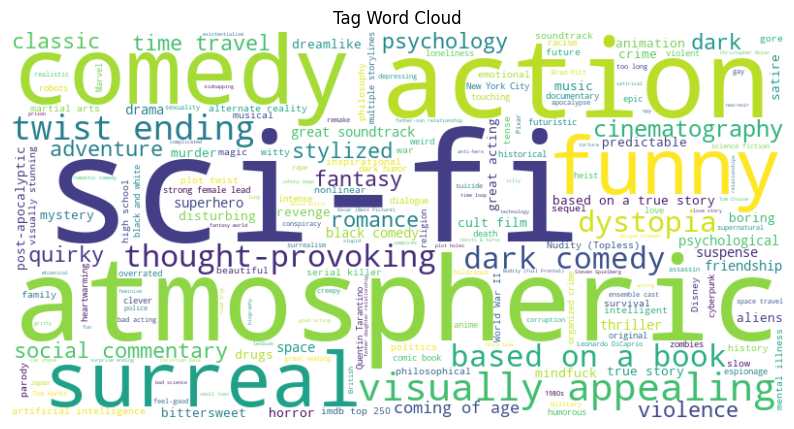

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Collect the top tags into a Pandas DataFrame
top_tags_pd = top_tags.toPandas()

# Create a dictionary of tag counts
tag_dict = dict(zip(top_tags_pd['tag'], top_tags_pd['count']))
stop = set(STOPWORDS) | {"movie", "film"}  # feel free to add more stopwords
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stop).generate_from_frequencies(tag_dict)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_dict)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tag Word Cloud")
plt.show()


## Average Rating per Genre
Sorted high → low; use to spot genres that consistently over/under-perform and to guide genre-aware baselines.

In [33]:
from pyspark.sql.functions import explode, avg, count

genres_exploded = final_df.withColumn("genre", explode("genres"))

avg_rating_per_genre = (
    genres_exploded
    .groupBy("genre")
    .agg(
        avg("rating").alias("avg_rating"),
        count("*").alias("rating_count")
    )
    .orderBy("avg_rating", ascending=False)  
)

avg_rating_per_genre.show()


+------------------+------------------+------------+
|             genre|        avg_rating|rating_count|
+------------------+------------------+------------+
|         Film-Noir|  3.93366368286445|        3128|
|               War|3.8669055317661454|       11443|
|             Crime|  3.84957201606733|       41824|
|         Animation|3.8262383191840224|       16373|
|             Drama| 3.825190640837399|      126678|
|           Mystery|3.8182326190843225|       25948|
|       Documentary|3.8011627906976746|        6020|
|           Musical|3.7844980752146875|        6754|
|           Western| 3.746814854974248|        3689|
|           Romance|3.7438470553765018|       40956|
|              IMAX|3.7058335309461703|       12651|
|          Thriller| 3.690898005042201|       72984|
|         Adventure|3.6709743548516762|       49756|
|           Fantasy|3.6684484406527664|       28249|
|          Children|3.6648257994136495|       14667|
|            Sci-Fi|3.6643600986571663|       

In [37]:
import plotly.express as px
import pandas as pd

avg_rating_per_genre_pd = (
    avg_rating_per_genre
    .toPandas()
    .sort_values(by="avg_rating", ascending=False)
)
median_val = avg_rating_per_genre_pd["avg_rating"].median()

fig = px.bar(
    avg_rating_per_genre_pd,
    x="avg_rating",
    y="genre",
    orientation="h",
    color="genre",
    text=avg_rating_per_genre_pd["avg_rating"].map(lambda x: f"{x:.2f}"),
    color_discrete_sequence=px.colors.qualitative.Set2,
    hover_data={"avg_rating": ":.2f"}
)
fig.update_traces(textposition="outside", texttemplate="%{text}", textfont_size=10)

fig.add_vline(
    x=median_val,
    line_dash="dash",
    line_color="red"
)
fig.add_annotation(
    x=median_val,
    y=0, yref="paper",
    text=f"Median: {median_val:.2f}",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=10, color="red"),
    bgcolor="rgba(255,255,255,0.8)"
)

fig.update_layout(
    title="Average Rating per Genre",
    title_x=0.5,
    xaxis_title="Average Rating",
    yaxis_title="Genre",
    showlegend=False,
    template="simple_white",
    height=700,
    margin=dict(l=140, r=160, t=70, b=60)
)

fig.show()


## Genre Trend Over Time (Every Ten Years)
Counts per decade for top genres; peaks show production booms, dips highlight quieter eras. Compare with average rating over time to see if popularity tracks quality.

In [ ]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import floor, explode

# Prep in Spark
final_df_with_interval = final_df.withColumn("year_interval", (floor(final_df["year"] / 10) * 10))
genres_exploded = final_df_with_interval.withColumn("genre", explode("genres"))
genre_trend = genres_exploded.groupBy("year_interval", "genre").count()

# To pandas
genre_trend_pd = genre_trend.toPandas()
genre_trend_pd["year_interval"] = pd.to_numeric(genre_trend_pd["year_interval"], errors="coerce")

# Top 10 genres by total count
top_10_genres = (
    genre_trend_pd.groupby("genre")
    .sum(numeric_only=True)
    .nlargest(10, "count")
    .index
    if not genre_trend_pd.empty else []
)
trend_top = genre_trend_pd[genre_trend_pd["genre"].isin(top_10_genres)].dropna(subset=["year_interval"])
trend_top = trend_top.sort_values(["genre", "year_interval"])

if trend_top.empty:
    print("No genre trend data to plot.")
else:
    fig = px.line(
        trend_top,
        x="year_interval",
        y="count",
        color="genre",
        markers=True,
        title="Genre Counts Over Time (Top Genres)",
        labels={"year_interval": "Year (by decade)", "count": "Movie Count"},
        color_discrete_sequence=px.colors.qualitative.Set2,
    )
    fig.update_layout(
        template="simple_white",
        title_x=0.5,
        height=600,
        margin=dict(l=60, r=200, t=60, b=60),
        legend_title="Genre"
    )
    fig.update_xaxes(dtick=10)
    fig.show()


### General Trends in Genre Popularity

We can spot each genre spikes or dips over time. Typically you will see more titles after the 1970s with visible peaks around the 1990s–2000s, and we see that all genres follow the same pattern expect drama with a more sharp raise.


## Average Rating Over Time
Shows how average ratings shift by release year; combine with residuals to detect eras where the model over/under-predicts.

In [41]:
# Calculate average rating per year
avg_rating_per_year = final_df.groupBy("year").avg("rating").orderBy("year")
avg_rating_per_year.show()


+----+------------------+
|year|       avg(rating)|
+----+------------------+
|1874|               5.0|
|1878|               5.0|
|1883|               3.0|
|1888|               2.5|
|1892|               2.5|
|1894|3.6666666666666665|
|1895| 2.576923076923077|
|1896|2.9722222222222223|
|1897| 3.238095238095238|
|1898|             3.375|
|1899|            3.3125|
|1900|3.2777777777777777|
|1901|               3.0|
|1902|              3.56|
|1903| 3.227272727272727|
|1904|3.0833333333333335|
|1905|2.8333333333333335|
|1906|               3.2|
|1907|               3.5|
|1908|3.3333333333333335|
+----+------------------+
only showing top 20 rows



In [ ]:
import plotly.express as px
import pandas as pd

avg_rating_per_year_pd = avg_rating_per_year.toPandas()
avg_rating_per_year_pd["year"] = pd.to_numeric(avg_rating_per_year_pd["year"], errors='coerce')
avg_rating_per_year_pd = avg_rating_per_year_pd.dropna().sort_values(by="year")

# Compute rolling mean if enough points
if len(avg_rating_per_year_pd) >= 5:
    avg_rating_per_year_pd["rolling"] = (
        avg_rating_per_year_pd["avg(rating)"].rolling(window=5, center=True).mean()
    )
else:
    avg_rating_per_year_pd["rolling"] = None

fig = px.line(
    avg_rating_per_year_pd,
    x="year",
    y="avg(rating)",
    markers=True,
    labels={"avg(rating)": "Average Rating", "year": "Year"},
    title="Average Rating per Year",
    color_discrete_sequence=["#4C78A8"]
)

# Add rolling mean if present
if avg_rating_per_year_pd["rolling"].notna().any():
    fig.add_scatter(
        x=avg_rating_per_year_pd["year"],
        y=avg_rating_per_year_pd["rolling"],
        mode="lines",
        name="5-yr rolling",
        line=dict(color="red", dash="dash")
    )

fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=60, t=60, b=60),
    legend_title=None
)
fig.show()


Average ratings fluctuate more in sparsely populated early years; post-1980 trends are more reliable due to higher volume.

# Machine learning or data mining algorithms using Spark MLlib

## Clustering

Bubbles summarize clusters by release year, rating, and size. Labels (C0/C1/…) plus sizes help compare cluster center shifts and density.

In [46]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, avg, count

# Cast and drop nulls
feature_df = (
    final_df.withColumn("year", col("year").cast("int"))
    .select("movieId", "rating", "year")
    .na.drop()
)
assembler = VectorAssembler(inputCols=["rating", "year"], outputCol="features")
feature_df = assembler.transform(feature_df)

feature_sample = feature_df.sample(fraction=0.05, seed=42)
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(feature_sample)
clusters = model.transform(feature_df)

cluster_summary = clusters.groupBy("prediction").agg(
    avg("year").alias("avg_year"),
    avg("rating").alias("avg_rating"),
    count("movieId").alias("movie_count"),
)


In [50]:
import plotly.express as px

# Make sure cluster_summary exists (run KMeans first)
cluster_summary_pd = cluster_summary.toPandas().sort_values("avg_year")

fig = px.scatter(
    cluster_summary_pd,
    x="avg_year",
    y="avg_rating",
    size="movie_count",
    color="prediction",
    hover_data={"movie_count": ":, "},
    labels={"avg_year": "Average Year", "avg_rating": "Average Rating"},
    title="Average Rating vs. Year by Cluster (size ~ movie_count)",
    color_discrete_sequence=px.colors.qualitative.Set2,
)
fig.update_traces(
    text=cluster_summary_pd["prediction"].map(lambda c: f"C{int(c)}"),
    textposition="top center",
    hovertemplate="Cluster C%{text}<br>Avg Year=%{x:.1f}<br>Avg Rating=%{y:.3f}<br>Movies=%{marker.size:,}",
    textfont_size=10
)
fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=80, t=60, b=60),
    yaxis=dict(range=[3.55, 3.85]),
    showlegend=True,
    legend_title="Cluster"
)

fig.show()


Bubbles show cluster centers by release year and rating; size reflects movie count, labels (C0/C1/…) identify clusters. Use to compare how clusters differ in era and quality.

## Classification

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import concat_ws, when, avg, count, first
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Aggregate to movie-level stats to keep the dataset lighter
movie_base = final_df.withColumn("genres_combined", concat_ws("|", "genres"))
movie_stats = movie_base.groupBy("movieId").agg(
    first("year").alias("year"),
    avg("rating").alias("avg_rating"),
    count("rating").alias("rating_count"),
    first("genres_combined").alias("genres_combined"),
)

# Label classes from average rating
labeled = movie_stats.withColumn(
    "rating_class",
    when(movie_stats["avg_rating"] > 4.0, 2)
    .when(movie_stats["avg_rating"] > 3.0, 1)
    .otherwise(0),
)

# Encode genres and assemble features
genre_indexer = StringIndexer(inputCol="genres_combined", outputCol="genres_indexed")
indexed = genre_indexer.fit(labeled).transform(labeled)
assembler = VectorAssembler(inputCols=["year", "rating_count", "genres_indexed"], outputCol="features")
feature_df = assembler.transform(indexed).na.drop()

# Optional: sample to reduce load
feature_sample = feature_df.sample(fraction=0.15, seed=42)

# Split data
train_df, test_df = feature_sample.randomSplit([0.8, 0.2], seed=42)

# Train classifier (higher maxBins for many genre buckets)
rf = RandomForestClassifier(featuresCol="features", labelCol="rating_class", numTrees=60, maxBins=2048, maxDepth=12)
rf_model = rf.fit(train_df)

# Predictions
rf_predictions = rf_model.transform(test_df)

# Evaluate
accuracy = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="accuracy").evaluate(rf_predictions)
precision = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="weightedPrecision").evaluate(rf_predictions)
recall = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="weightedRecall").evaluate(rf_predictions)
f1 = MulticlassClassificationEvaluator(labelCol="rating_class", metricName="f1").evaluate(rf_predictions)
print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

# Confusion matrix (normalized)
rf_predictions_pd = rf_predictions.select("rating_class", "prediction").limit(3000).toPandas()
conf_matrix = confusion_matrix(rf_predictions_pd["rating_class"], rf_predictions_pd["prediction"], normalize="true")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"], cbar_kws={"label": "Proportion"})
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

# Preview a small sample of predictions
sample_preds = rf_predictions.select("movieId", "avg_rating", "rating_class", "prediction").limit(10).toPandas()
print(sample_preds.head())


### Model Performance Overview

Interpret metrics (Accuracy/Precision/Recall/F1) with the normalized confusion matrix. Adjacent-class confusion is expected; adjust sampling/features or tree params if metrics are weak.

## Regression

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import avg, count, first, concat_ws

# Aggregate to movie-level stats
movie_base = final_df.withColumn("genres_combined", concat_ws("|", "genres"))
movie_stats = movie_base.groupBy("movieId").agg(
    avg("rating").alias("avg_rating"),
    count("rating").alias("rating_count"),
    first("year").alias("year"),
    first("genres_combined").alias("genres_combined"),
)

# Encode genres and assemble features
genre_indexer = StringIndexer(inputCol="genres_combined", outputCol="genres_indexed")
indexed = genre_indexer.fit(movie_stats).transform(movie_stats)
assembler = VectorAssembler(inputCols=["year", "rating_count", "genres_indexed"], outputCol="features")
feature_df = assembler.transform(indexed).na.drop()

# Split data
train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed=42)

# Train regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="avg_rating", maxBins=1500)
rf_model = rf.fit(train_df)

# Predictions
predictions = rf_model.transform(test_df)

# Evaluate
rmse = RegressionEvaluator(labelCol="avg_rating", predictionCol="prediction", metricName="rmse").evaluate(predictions)
print(f"RMSE: {rmse:.4f}")

predictions.select("movieId", "avg_rating", "prediction").show(10)


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd

predictions_pd = predictions.select("avg_rating", "prediction").toPandas()

x = predictions_pd["avg_rating"]
y = predictions_pd["prediction"]
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())

# Fit simple regression line
m, b = np.polyfit(x, y, 1)

fig = px.scatter(
    predictions_pd,
    x="avg_rating",
    y="prediction",
    opacity=0.4,
    color_discrete_sequence=["#2a9d8f"],
    title="Predicted vs Actual Average Rating",
    labels={"avg_rating": "Actual Avg Rating", "prediction": "Predicted Avg Rating"},
)

# Perfect fit line
fig.add_shape(
    type="line",
    x0=min_val, y0=min_val, x1=max_val, y1=max_val,
    line=dict(color="red", dash="dash"),
    name="Perfect Fit"
)

# Regression line
fig.add_trace(
    go.Scatter(
        x=[min_val, max_val],
        y=[m * min_val + b, m * max_val + b],
        mode="lines",
        line=dict(color="orange", dash="dot"),
        name="Regression"
    )
)

fig.update_layout(
    template="simple_white",
    title_x=0.5,
    height=500,
    margin=dict(l=60, r=60, t=60, b=60),
    showlegend=False
)
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color="white")))
fig.show()


### Baseline vs Model RMSE

Compare the regression model against a simple global-mean baseline on the same test split.

In [ ]:
import math
import pandas as pd
from pyspark.sql.functions import avg as spark_avg

# Global mean across movies
global_mean = movie_stats.agg(spark_avg("avg_rating").alias("global_mean")).first()["global_mean"]

pred_pd = predictions.select("avg_rating", "prediction").toPandas()
model_rmse = math.sqrt(((pred_pd["prediction"] - pred_pd["avg_rating"]) ** 2).mean())
baseline_rmse = math.sqrt(((pred_pd["avg_rating"] - global_mean) ** 2).mean())
print(f"Model RMSE: {model_rmse:.4f} | Baseline RMSE (global mean): {baseline_rmse:.4f}")


### Residuals by Release Year

Residual = prediction − actual. Near-zero lines mean balanced predictions; positive means over-prediction, negative under-prediction. Align this with the average-rating-per-year trend to spot era bias.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg as spark_avg

residuals_by_year = (
    predictions
    .select("year", "avg_rating", "prediction")
    .groupBy("year")
    .agg(
        spark_avg(col("prediction") - col("avg_rating")).alias("avg_residual"),
        spark_avg("avg_rating").alias("avg_rating"),
    )
    .orderBy("year")
)

residuals_pd = residuals_by_year.toPandas()
residuals_pd["year"] = pd.to_numeric(residuals_pd["year"], errors="coerce")
residuals_pd = residuals_pd.dropna(subset=["year", "avg_residual"])

plt.figure(figsize=(8, 5))
sns.lineplot(x="year", y="avg_residual", data=residuals_pd, marker="o")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Average Residual by Release Year (prediction - actual)")
plt.xlabel("Year")
plt.ylabel("Average Residual")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Regression Line Fit

Points close to the red identity line mean good predictions; RMSE printed above gives the magnitude of error. Use this with the residuals plot to identify systematic bias.

## Association rule mining

In [ ]:
from pyspark.sql.functions import collect_list, flatten, array_distinct
from pyspark.ml.fpm import FPGrowth

# Prepare transactions of genres (flatten the nested array and ensure distinct genres)
transactions_df = final_df.groupBy("movieId").agg(array_distinct(flatten(collect_list("genres"))).alias("genres_list"))

# FP-Growth model
fp_growth = FPGrowth(itemsCol="genres_list", minSupport=0.01, minConfidence=0.1)
fp_model = fp_growth.fit(transactions_df)

# Frequent itemsets
fp_model.freqItemsets.show()

# Association rules
fp_model.associationRules.show()



### Frequent Itemsets Table:
- This table lists **combinations of genres** (itemsets) and their frequencies.
  - Example: **Sci-Fi** appears in **2,315 movies**, and the combination **Sci-Fi, Thriller** appears in **622 movies**.
- These itemsets help identify **common genre combinations** in the dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

freq_itemsets_df = fp_model.freqItemsets.toPandas()
freq_itemsets_df["items_str"] = freq_itemsets_df["items"].apply(lambda x: ', '.join(x))
freq_itemsets_df = freq_itemsets_df.sort_values(by="freq", ascending=False).head(10)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("crest", len(freq_itemsets_df))
ax = sns.barplot(x="freq", y="items_str", data=freq_itemsets_df, hue="items_str", palette=palette, dodge=False, legend=False)
plt.title("Top 10 Frequent Genre Itemsets")
plt.xlabel("Frequency")
plt.ylabel("Itemset")

for i, v in enumerate(freq_itemsets_df["freq"]):
    ax.text(v + max(freq_itemsets_df["freq"]) * 0.01, i, f"{int(v):,}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


### Top 10 Frequent Genre Itemsets

Most common genre combinations; annotations show frequency. Use to sanity-check genre co-occurrence before looking at association rules.

In [ ]:
# Convert the association rules to a Pandas DataFrame
association_rules_df = fp_model.associationRules.toPandas()

# Convert the 'antecedent' and 'consequent' columns from lists to strings for plotting
association_rules_df["antecedent_str"] = association_rules_df["antecedent"].apply(lambda x: ', '.join(x))
association_rules_df["consequent_str"] = association_rules_df["consequent"].apply(lambda x: ', '.join(x))

# Sort by confidence
association_rules_df = association_rules_df.sort_values(by="confidence", ascending=False)

# Prepare the data for heatmap (using confidence as values)
plt.figure(figsize=(10, 6))
rules_matrix = pd.pivot_table(association_rules_df, values="confidence", index="antecedent_str", columns="consequent_str", aggfunc='mean')

# Plot heatmap
sns.heatmap(rules_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Association Rules Heatmap (Confidence)")
plt.xlabel("Consequent")
plt.ylabel("Antecedent")
plt.show()


### Association Rules Heatmap (Confidence)

Brighter cells = higher confidence for antecedent → consequent. Focus on strong pairs and compare against the frequent itemsets to validate patterns.

In [ ]:
# Plot scatter plot of confidence vs lift
plt.figure(figsize=(8, 6))
sns.scatterplot(x="confidence", y="lift", data=association_rules_df)
plt.title("Confidence vs Lift of Association Rules")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.show()


###  Confidence vs. Lift Scatter Plot:
- This scatter plot compares the confidence and lift values of association rules.
- Lift measures how much more likely the items in the consequent are observed together than if they were randomly associated. Values greater than 1 indicate a strong association.
- Some rules have both high lift and high confidence, indicating strong relationships between genres, while others may have lower confidence and lift values.